Graduate project notebook
Uhh.. ignore it I guess.

In [ ]:
'''
from google.colab import drive
%pip install automata-lib
%pip install torchview

!git clone https://github.com/FaultyTwo/anns.git
'''

In [1]:
import torch, torchvision

# seeding for reliable result
batch_size_train = 128
batch_size_test = 1000
random_seed = 1
torch.manual_seed(random_seed)

if torch.cuda.is_available():
    print("its cuda! hooray!")
    device = 'cuda:0'
else:
    device = 'cpu'

if torch.cuda.is_available():
  torch.cuda.manual_seed(random_seed)
  torch.cuda.manual_seed_all(random_seed)

train_loader = torch.utils.data.DataLoader(
                            torchvision.datasets.CIFAR10('data/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                            ])),
                            batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
                            torchvision.datasets.CIFAR10('data/', train=False, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                            ])),
                            batch_size=batch_size_test, shuffle=True)

its cuda! hooray!
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Get path
import sys
sys.path.insert(0,'/anns')

In [46]:
from model.ModelBuilder import ModelBuilder
from dict_obj.DictProcess import DictProcess
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

jason = {1: 'C22', 2: 'P22', 3: "C22", 4: 'C44', 5: "C22", 6: 'P44', 7:'F10', 
         'con': {1: None, 2: 1, 3: [2, 1], 4: [3, 2], 5: [4, 1], 6: [5, 3, 1], 7: 6}}

chromosome = DictProcess.dict_to_chromosome(jason)
print(chromosome)

model = ModelBuilder(chromosome,data_shape=[1,3,32,32])
model.add_module("softmax",torch.nn.Softmax(dim=1))
model = model.to(torch.device(device))
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(total_params)


C22R1R3R4P22R1R2C22R2R4C44R3C22R4P44F10
[[1, 32, 32, 32], 'R1', 'R3', 'R4', [1, 32, 16, 16], 'R1', 'R2', [1, 32, 16, 16], 'R2', 'R4', [1, 32, 16, 16], 'R3', [1, 32, 16, 16], 'R4', [1, 32, 4, 4]]
ModelBuilder(
  (fake_sequence): ModuleDict(
    (sect0): Sequential(
      (conv0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), dilation=(2, 2))
      (batch_norm0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU()
    )
    (sect4): Sequential(
      (pool0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (sect7): Sequential(
      (conv0): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), dilation=(2, 2))
      (batch_norm0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU()
    )
    (sect10): Sequential(
      (conv0): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3), dilation=(2, 2))
  

In [47]:
import matplotlib.pyplot as plt

# in report, report testing condition
# 32 epochs, ADAM optimizer with learning rate of 0.001 (and default)
# CrossEntrypyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 32

epoch_plot = []
train_loss_plot = []

# Train
print("Training And Testing ... please wait")
model.train()
for x in range(epochs):
  print("Epoch:", x+1)
  for idx,(data, target) in enumerate(train_loader):
    data = data.to(torch.device(device))
    target = target.to(torch.device(device))
    optimizer.zero_grad()
    output = model(data)
    #print(output.shape,target.shape)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
    if idx % 100 == 0:
      print('Batch Enum: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            idx, idx * len(data), len(train_loader.dataset),
            100. * idx / len(train_loader), loss.item()))
  epoch_plot.append(x + 1)
  train_loss_plot.append(loss.item())

# Test
model.eval()
test_loss = 0
correct = 0
print("== Testing ==")
with torch.no_grad():
  for data, target in test_loader:
    data = data.to(torch.device(device))
    target = target.to(torch.device(device)) # casting data to whatever
    output = model(data)
    test_loss += loss_fn(output, target).item()
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
  print('Test Set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

print("Model Accuracy:", float(100. * correct / len(test_loader.dataset)), "%")
# get total parameters inside 'model'

Training And Testing ... please wait
Epoch: 1
Batch Enum: 0 [0/50000 (0%)]	Loss: 2.554106
Batch Enum: 100 [12800/50000 (26%)]	Loss: 2.295618
Batch Enum: 200 [25600/50000 (51%)]	Loss: 2.248013
Batch Enum: 300 [38400/50000 (77%)]	Loss: 2.253054
Epoch: 2
Batch Enum: 0 [0/50000 (0%)]	Loss: 2.288788
Batch Enum: 100 [12800/50000 (26%)]	Loss: 2.289626
Batch Enum: 200 [25600/50000 (51%)]	Loss: 2.239283
Batch Enum: 300 [38400/50000 (77%)]	Loss: 2.238275
Epoch: 3
Batch Enum: 0 [0/50000 (0%)]	Loss: 2.206177
Batch Enum: 100 [12800/50000 (26%)]	Loss: 2.260477
Batch Enum: 200 [25600/50000 (51%)]	Loss: 2.281542
Batch Enum: 300 [38400/50000 (77%)]	Loss: 2.247194
Epoch: 4
Batch Enum: 0 [0/50000 (0%)]	Loss: 2.298432
Batch Enum: 100 [12800/50000 (26%)]	Loss: 2.108271
Batch Enum: 200 [25600/50000 (51%)]	Loss: 2.236386
Batch Enum: 300 [38400/50000 (77%)]	Loss: 2.275679
Epoch: 5
Batch Enum: 0 [0/50000 (0%)]	Loss: 2.285001
Batch Enum: 100 [12800/50000 (26%)]	Loss: 2.186237
Batch Enum: 200 [25600/50000 (51%)]

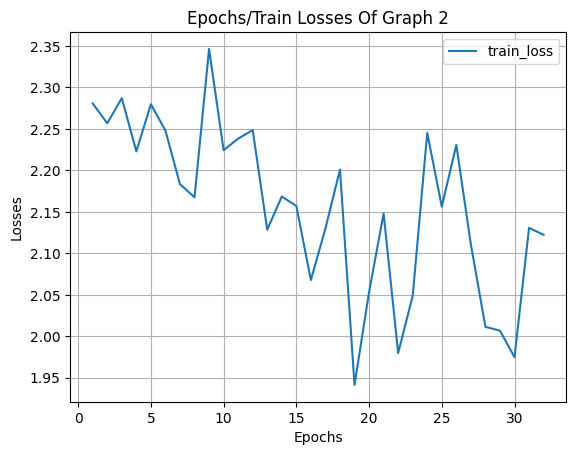

In [50]:
# plotting the graph
import numpy as np

epoch_plot = np.array(epoch_plot)
train_loss_plot = np.array(train_loss_plot)

#np.save('epoch_plot', epoch_plot)
np.save('train_loss_plot',train_loss_plot)

plt.figure(1)
plt.plot(epoch_plot, train_loss_plot, label="train_loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.grid()
plt.title("Epochs/Train Losses Of " + "Graph 2")
plt.legend()
plt.show()


In [49]:
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

model_graph = draw_graph(model, input_size=[1,3,32,32])
model_graph.visual_graph.render("model_graph",format="svg")


(dot.exe:12828): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


'model_graph.svg'

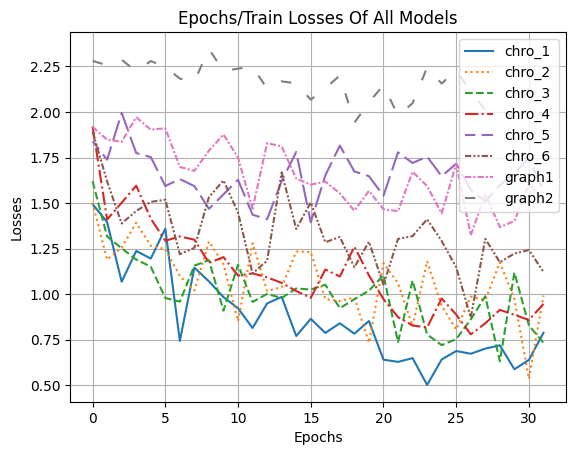

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

path = Path("D:/Python/Machine Learning ENV/nn-clean-results")

chro = []
for x in range(6):
    doc = "chro_" + str(x + 1) + "_loss_res.npy"
    chro.append(np.load(path / doc))
for x in range(2):
    doc = "graph_" + str(x + 1) + "_loss_res.npy"
    chro.append(np.load(path / doc))

# lis
ls = ['solid','dotted','dashed','dashdot', (5, (10, 3)), (0,(3,1,1,1,1,1)), (0,(3,1,1,1)), (0,(5,10))]

plt.figure(2)
for x in range(8):
    if x < 6:
        blah = "chro_" + str(x + 1)
    else:
        blah = "graph" + str(x - 5)
    plt.plot(range(0,32), chro[x], label=blah, linestyle=ls[x])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.grid()
plt.title("Epochs/Train Losses Of All Models")
plt.legend()
plt.show()